In [6]:
!pip install -q imbalanced-learn shap joblib


✅ Date încărcate.
🚀 Începere GridSearch Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best CV ROC-AUC: 0.9548
Best Params: {'clf__class_weight': 'balanced', 'clf__max_depth': None, 'clf__min_samples_leaf': 4, 'clf__n_estimators': 200}

=== REZULTATE RANDOM FOREST PE TEST ===
Accuracy:  0.9442
Precision: 0.9267
Recall:    0.9145
F1 Score:  0.9205
ROC AUC:   0.9412

Top 5 Configurații RF:


,param_clf__class_weight,param_clf__max_depth,param_clf__min_samples_leaf,param_clf__n_estimators,Mean ROC-AUC,std_test_score,rank_test_score
35,None,None,4,200,0.954756,0.008937,1
17,balanced,None,4,200,0.954756,0.008937,1
11,balanced,20,4,200,0.954719,0.008910,3
29,None,20,4,200,0.954719,0.008910,3
10,balanced,20,4,100,0.954419,0.009050,5


/tmp/ipython-input-1412117461.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_15, x='Mean ROC-AUC', y='Label', palette='Greens_r')


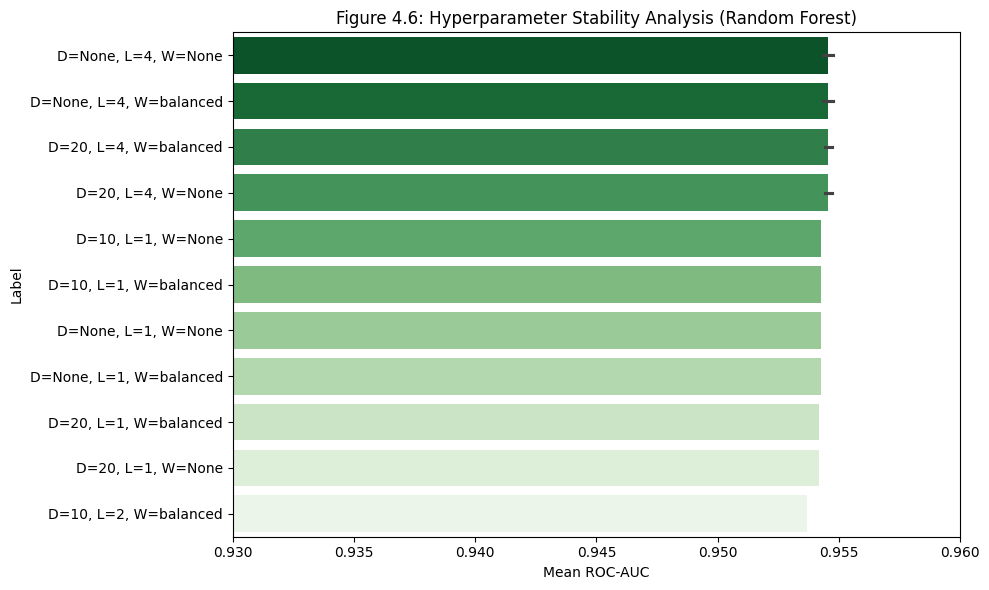

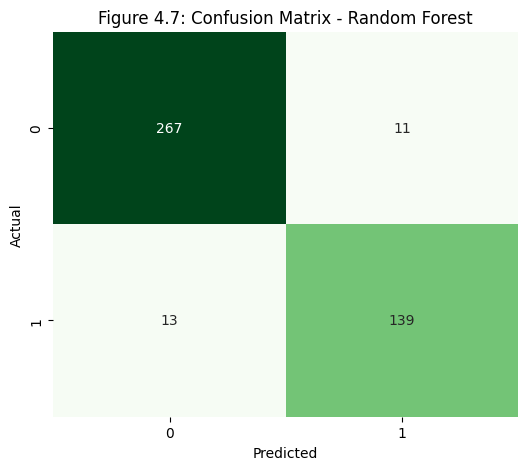

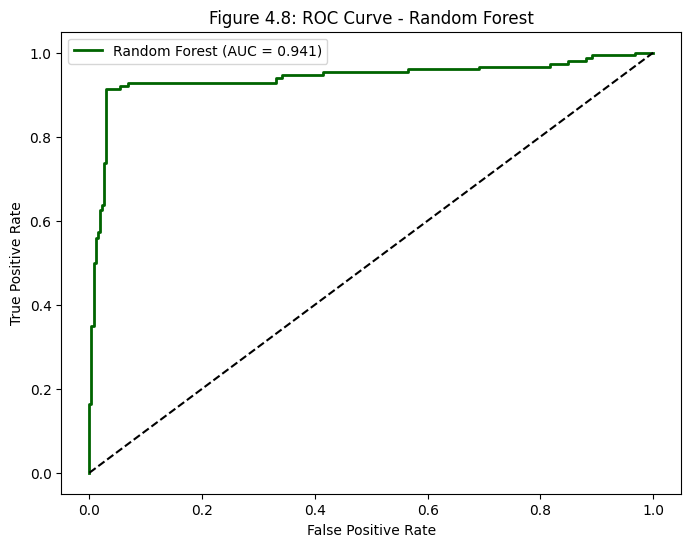

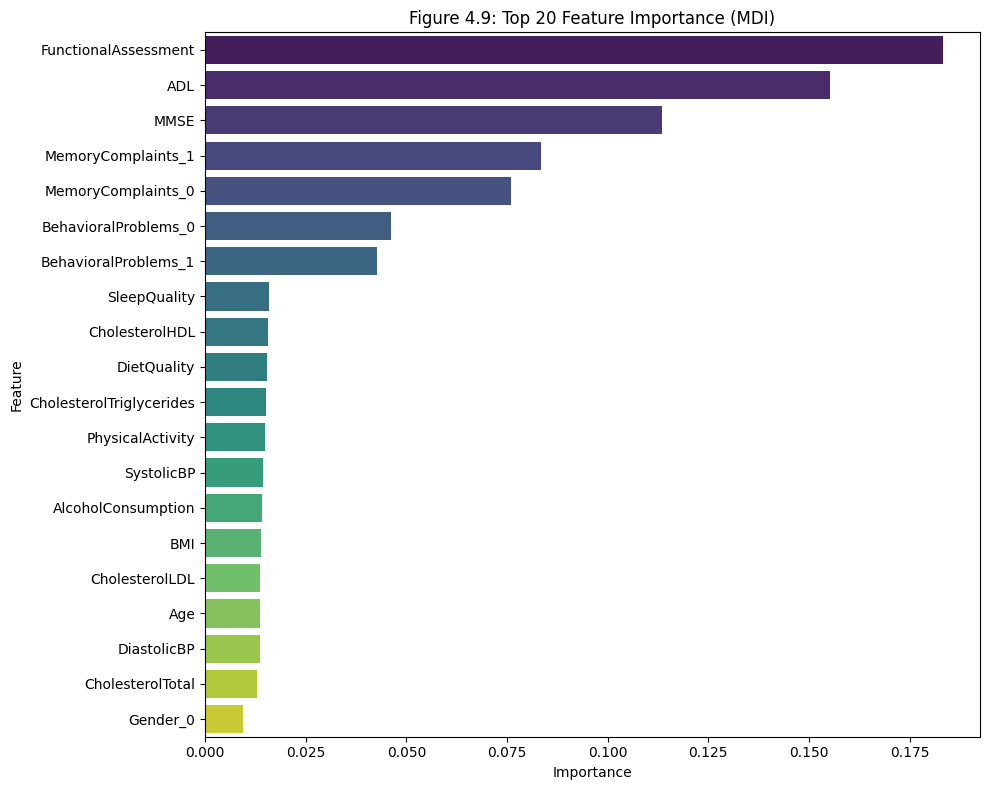

In [2]:
# ==============================================================================
# EXPERIMENT 2: RANDOM FOREST (Complete & Fixed)
# ==============================================================================

# 1. IMPORTURI (Inclusiv cel care lipsea)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, roc_curve)

# --- IMPORT CRITIC ADĂUGAT ---
from sklearn.pipeline import Pipeline
# -----------------------------

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# 2. SETARE SEED & ÎNCĂRCARE DATE
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ⚠️ Verifică calea!
file_path = '/content/drive/MyDrive/AMDA/alzheimers_disease_data.csv'
try:
    df = pd.read_csv(file_path)
    print("✅ Date încărcate.")
except FileNotFoundError:
    print("❌ Eroare: Fișierul nu a fost găsit.")

# 3. CURĂȚARE & PREGĂTIRE
if 'PatientID' in df.columns:
    df = df.drop(columns=['PatientID'])
y = df['Diagnosis']
X = df.drop(columns=['Diagnosis'])
cols_to_drop = ['DoctorInCharge', 'Doctor', 'XXXConfid']
X = X.drop(columns=[c for c in cols_to_drop if c in X.columns])

# Split Stratificat
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Identificare coloane
cat_cols_manual = ['Gender', 'Ethnicity', 'EducationLevel', 'Smoking',
                   'FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes',
                   'Depression', 'HeadInjury', 'Hypertension', 'MemoryComplaints',
                   'BehavioralProblems', 'Confusion', 'Disorientation',
                   'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness']

all_num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
all_cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
final_cat_cols = list(set(all_cat_cols + [c for c in cat_cols_manual if c in X.columns]))
final_num_cols = [c for c in all_num_cols if c not in final_cat_cols]

# 4. PIPELINE FĂRĂ SCALARE (Specific RF)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
    # FĂRĂ StandardScaler
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, final_num_cols),
    ('cat', categorical_transformer, final_cat_cols)
])

# 5. MODEL & GRID SEARCH
rf_clf = RandomForestClassifier(random_state=RANDOM_STATE)

pipeline_rf = ImbPipeline(steps=[
    ('preproc', preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('clf', rf_clf)
])

param_grid_rf = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [10, 20, None],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__class_weight': ['balanced', None]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print("🚀 Începere GridSearch Random Forest...")
grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)

best_model_rf = grid_rf.best_estimator_
print(f"Best CV ROC-AUC: {grid_rf.best_score_:.4f}")
print(f"Best Params: {grid_rf.best_params_}")

# 6. EVALUARE & METRICI TEST
y_pred_rf = best_model_rf.predict(X_test)
y_proba_rf = best_model_rf.predict_proba(X_test)[:, 1]

print("\n=== REZULTATE RANDOM FOREST PE TEST ===")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba_rf):.4f}")

# 7. VIZUALIZĂRI PENTRU RAPORT (FIGURILE 4.6 - 4.9)

# A. Analiza Stabilității Hiperparametrilor (NOU)
results_rf = pd.DataFrame(grid_rf.cv_results_)
param_cols = [col for col in results_rf.columns if col.startswith('param_')]
cols_to_keep = param_cols + ['mean_test_score', 'std_test_score', 'rank_test_score']
comparison_rf = results_rf[cols_to_keep].copy()
comparison_rf.rename(columns={'mean_test_score': 'Mean ROC-AUC'}, inplace=True)
comparison_rf = comparison_rf.sort_values(by='Mean ROC-AUC', ascending=False)

# Afișare tabel top 5
print("\nTop 5 Configurații RF:")
display(comparison_rf.head(5))

# Plot Stabilitate
plt.figure(figsize=(10, 6))
# Facem un label scurt
def make_label(row):
    return f"D={row['param_clf__max_depth']}, L={row['param_clf__min_samples_leaf']}, W={row['param_clf__class_weight']}"
comparison_rf['Label'] = comparison_rf.apply(make_label, axis=1)

# Luăm top 15 variante
top_15 = comparison_rf.head(15)
sns.barplot(data=top_15, x='Mean ROC-AUC', y='Label', palette='Greens_r')
plt.xlim(0.93, 0.96) # Zoom pe zona relevantă
plt.title('Figure 4.6: Hyperparameter Stability Analysis (Random Forest)')
plt.xlabel('Mean ROC-AUC')
plt.tight_layout()
plt.show()

# B. Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Figure 4.7: Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# C. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_proba_rf):.3f})', color='darkgreen', lw=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Figure 4.8: ROC Curve - Random Forest')
plt.legend()
plt.show()

# D. Feature Importance
# Extragem numele feature-urilor
def get_feature_names(model):
    preproc = model.named_steps['preproc']
    cat_trans = preproc.named_transformers_['cat']['onehot']
    cat_names = cat_trans.get_feature_names_out(final_cat_cols)
    return np.r_[final_num_cols, cat_names]

feat_names = get_feature_names(best_model_rf)
importances = best_model_rf.named_steps['clf'].feature_importances_
feat_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feat_df, hue='Feature', palette='viridis', legend=False)
plt.title('Figure 4.9: Top 20 Feature Importance (MDI)')
plt.tight_layout()
plt.show()